In [19]:
from sympy import *
from sympy.abc import r,x,y,z
from sympy import init_printing
from cubature import cubature
import sympy.printing.llvmjitcode as jit
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline
init_printing()

# Energy of a Helium atom

The Hamiltonian for this system is
$$-\frac{1}{2} (\nabla_1^2 + \nabla_2^2) - \frac{2}{r_1} - \frac{2}{r_2} + \frac{1}{r_{12}}$$

The first two terms are the kinetic energy, the next two are the electron-nuclear Coulomb interaction, and the final term is the electron-electron Coulomb interaction.


In [21]:
r1 = Symbol('r1')    # magnitude of vector r1 (electron 1 to nucleus distance)
r2 = Symbol('r2')    # magnitude of vector r2 (electron 2 to nucleus distance)
r12 = Symbol('r12') # |r2-r1| (magnitude of vector r2-r1)


### Simple trial wavefunction

This trial wavefunction uses a Slater form for the electon-nuclear interactions.  The value in the exponent (-2) is fixed by the cusp condition.   The electron-electron interaction uses a simple Pade form.   There is one adjustable parameter, $\beta$.   The integration occurs over the spatial coordinates of each electron, giving a 6 dimensional integral.

In the QMCPACK distribution, the example input file in `examples/molecules/He/simple_he.xml` has the same wavefunction.

In [22]:
beta = Symbol('beta')
R1 = exp(-2*r1)
R2 = exp(-2*r2)
G = exp(r12/2/(1 + beta*r12))
R1*R2*G

In [23]:
def del_spherical(e, r):
    """Compute Laplacian for expression e with respect to symbol r.
        Currently works only with radial dependence"""
    t1 = r*r*diff(e, r)
    t2 = diff(t1, r)/(r*r)
    return simplify(t2)

def grad_spherical(e, r, rhat):
    """Compute gradient for expresion e with respect to symbol r.
       The symbol rhat is the unit vector in the radial direction."""
    t1 = diff(e, r)
    t2 = simplify(t1)
    return t2*rhat



In [24]:
# Wavefunction has the form F1 * F2 * G
# grad (FG) = G grad(F) + F grad(G)

def grad_combo(F, gradF, G, gradG):
    t = F*gradG + G*gradF
    return simplify(t)

# del^2 (FG) = G del^2(F0 + F del^2(G) + 2 grad(F) * grad(G)
def del_combo(F, gradF, delsqF, G, gradG, delsqG):
    t = G * delsqF + F * delsqG + 2*gradF*gradG
    t2 = t.subs(rhat1*rhat1, 1)
    t3 = t2.subs(rhat2*rhat2, 1)
    t4 = t3.subs(rhat12*rhat12, 1)
    t5 = t4.subs(rhat1*rhat12, rhat1_12)
    t6 = t5.subs(rhat2*rhat12, rhat2_12)
    return simplify(t6)


In [25]:
# Unit vectors
rhat1 = Symbol('rhat1')
rhat2 = Symbol('rhat2')
rhat12 = Symbol('rhat12')
rhat1_12 = Symbol('rhat1_12')
rhat2_12 = Symbol('rhat2_12')

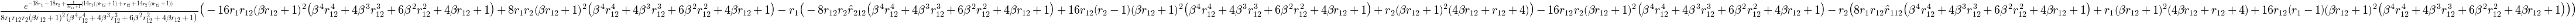

In [26]:
# TODO: Explain this derivation
grad_1 = grad_spherical(R1, r1, rhat1)
del2_1 = del_spherical(R1, r1)

grad_2 = grad_spherical(R2, r2, rhat2)
del2_2 = del_spherical(R2, r2)

gradG_1 = grad_spherical(G, r12, rhat12)
del2G_1 = del_spherical(G, r12)

grad_R1G = grad_combo(R1, grad_1, G, -gradG_1)

delsq_R1G = del_combo(R1, grad_1, del2_1, G, -gradG_1, del2G_1)


grad_R2G = grad_combo(R2, grad_2, G, gradG_1)
delsq_R2G = del_combo(R2, grad_2, del2_2, G, gradG_1, del2G_1)

# This is the integrand for the denominator
psi2 = R1*R1*R2*R2*G*G

h1 = -1/S(2) * (R2*R2) * R1 * G * delsq_R1G - 2*psi2/r1
h2 = -1/S(2) * (R1*R1) * R2 * G * delsq_R2G - 2*psi2/r2
h = h1 + h2 + psi2/r12
h = simplify(h)
# This is the integrand for the numerator
h

In [27]:
# Symbols for performing the integration
x1,y1,z1 = symbols('x1 y1 z1')
x2,y2,z2 = symbols('x2 y2 z2')
# Add a very tiny softening to keep the evaluation of the integrand from blowing up at certain points.
r1_c = sqrt(x1*x1 + y1*y1 + z1*z1 + 1e-20)
r2_c = sqrt(x2*x2 + y2*y2 + z2*z2 + 1e-20)
r12_c = sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1) + (z2-z1)*(z2-z1) + 1e-20)
rhat1_12_c = (x1*(x2-x1) + y1*(y2-y1) + z1*(z2-z1))/r1_c/r12_c
rhat2_12_c = (x2*(x2-x1) + y2*(y2-y1) + z2*(z2-z1))/r2_c/r12_c

In [42]:
# Perform 6D integral. Using scipy.integrate.nquad will take too long.
# Use Cubature and Sympy LLVM JIT 
#  TODO: insert link to explain different integrators

beta_val = 1.0
num = tmp.subs(beta, beta_val)
denom = simplify(tmp2.subs(beta, beta_val))

ndim = 6
lim_min = [-30.0]*ndim
lim_max = [30.0]*ndim

repls = [(r1, r1_c), (r2, r2_c), (r12, r12_c), (rhat1_12, rhat1_12_c), (rhat2_12, rhat2_12_c)]
repls_n = [a for a in repls]
tmp_h = h.subs(beta, beta_val)
tmp_d = psi2.subs(beta, beta_val)

# Use CSE (Common Subexpression Elimination) to speed up the integrand evaluation
cse_h = cse([tmp_h, tmp_d])
repls.extend(cse_h[0])
expr_h = [repls, cse_h[1]]

jit_expr = jit.llvm_callable( [x1, y1, z1, x2, y2, z2], expr_h, callback_type='cubature')

epsrel = 1e-4
start = timer()
res = cubature(jit_expr, ndim=ndim, fdim=2, xmin=lim_min, xmax=lim_max, relerr=epsrel)
end = timer()
E = res[0][0]/res[0][1]
print("For beta = ",beta_val," Energy = ",E)
print("Time: %.2f seconds"%(end-start))

For beta =  1.0  Energy =  -2.82611479297
Time: 96.18 seconds


In [15]:
# Collect computation of energy into a single function
def compute_energy(beta_val):

    repls = [(r1, r1_c), (r2, r2_c), (r12, r12_c), (rhat1_12, rhat1_12_c), (rhat2_12, rhat2_12_c)]
    repls_n = [a for a in repls]
    tmp_h = h.subs(beta, beta_val)
    tmp_d = psi2.subs(beta, beta_val)

    cse_h = cse([tmp_h,tmp_d])
    repls.extend(cse_h[0])
    expr_h = [repls, cse_h[1]]

    jit_expr = jit.llvm_callable( [x1, y1, z1, x2, y2, z2], expr_h, callback_type='cubature')

    epsrel = 1e-4
    res = cubature(jit_expr, ndim=ndim, fdim=2, xmin=lim_min, xmax=lim_max, relerr=epsrel)
    E = res[0][0]/res[0][1]

    return E

In [31]:
# Compute energies over a range of variational parameters to find the minimum.
energies = []
betas = []
for i in range(10):
    beta_val = i*.02 + 0.01
    e = compute_energy(beta_val)
    print(beta_val, e)
    betas.append(beta_val)
    energies.append(e)

0.01 -2.86001117585
0.03 -2.86676650391
0.05 -2.87135272931
0.06999999999999999 -2.87442400954
0.09 -2.87639789443
0.11 -2.87755791558
0.13 -2.8781022511
0.15000000000000002 -2.87817447072
0.17 -2.87788106408
0.19 -2.87730296758


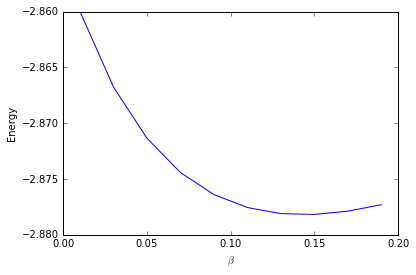

In [40]:
fig = plt.plot(betas, energies)
fig[0].axes.set_xlabel(r"$\beta$")
fig[0].axes.set_ylabel("Energy")